In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import folium

### High quality individuals

In [2]:
hq_migration_data = pd.read_csv('data/migration_hq.csv')

In [3]:
#Convert the location data to geometry points
hq_migration_data['geometry'] = hq_migration_data.apply(lambda row: Point(row['location-long'], row['location-lat']), axis=1)

In [4]:
#Create a GeoDataFrame
hq_gdf = gpd.GeoDataFrame(hq_migration_data, geometry='geometry')

In [5]:
#Group the data by individual and create a GeoSeries for each one
hq_individuals = hq_gdf.groupby('id_year')
hq_individual_geoseries = {name: gpd.GeoSeries(group['geometry']) for name, group in hq_individuals}

hq_individual_geoseries

{'14542E_2001': 0      POINT (-0.51300 35.12700)
 1      POINT (-0.46900 35.20000)
 2      POINT (-0.55600 35.27000)
 3      POINT (-0.52700 35.27000)
 4      POINT (-0.48800 35.24900)
                  ...            
 130    POINT (-3.36300 34.25300)
 131    POINT (-3.23500 34.25100)
 132    POINT (-3.27200 34.20700)
 133    POINT (-3.40500 34.32200)
 134    POINT (-3.32900 34.22400)
 Name: geometry, Length: 135, dtype: geometry,
 '14551E_1997': 135    POINT (37.91500 -1.56300)
 136    POINT (37.97500 -1.53100)
 137    POINT (37.89800 -1.59400)
 138    POINT (37.90800 -1.64700)
 139    POINT (37.85600 -1.10100)
                  ...            
 426     POINT (37.22600 3.88100)
 427     POINT (37.18200 3.94600)
 428     POINT (37.02100 3.84100)
 429     POINT (37.18400 4.01900)
 430     POINT (37.28000 4.08400)
 Name: geometry, Length: 296, dtype: geometry,
 '14551E_1998': 431     POINT (37.01700 3.86200)
 432     POINT (37.01900 3.87700)
 433     POINT (37.11200 3.95400)
 434     PO

Extracting features from the geoseries in order to perform the clustering

In [6]:
def calculate_total_distance(geoseries):
    total_distance = 0
    points = geoseries.tolist()  #Convert GeoSeries to a list of Points

    #Calculate the distance between each consecutive point
    for i in range(len(points) - 1):
        total_distance += geodesic((points[i].y, points[i].x), (points[i+1].y, points[i+1].x)).kilometers

    return total_distance

In [7]:
def calculate_min_max_lat_long(geoseries):
    #Extracting latitude and longitude from each point
    latitudes = [point.y for point in geoseries]
    longitudes = [point.x for point in geoseries]

    #Calculating minimum and maximum latitude and longitude
    min_latitude = min(latitudes)
    max_latitude = max(latitudes)
    min_longitude = min(longitudes)
    max_longitude = max(longitudes)

    return min_latitude, max_latitude, min_longitude, max_longitude

In [66]:
# Apply the functions to each individual's GeoSeries
hq_individual_distances = {name: calculate_total_distance(geoseries) for name, geoseries in hq_individual_geoseries.items()}
hq_individual_min_max_lat_long = {name: calculate_min_max_lat_long(geoseries) for name, geoseries in hq_individual_geoseries.items()}

# Convert the features to a DataFrame for clustering
hq_individual_distances_df = pd.DataFrame.from_dict(hq_individual_distances, orient='index', columns=['total_distance'])
hq_individual_min_max_lat_long_df = pd.DataFrame.from_dict(hq_individual_min_max_lat_long, orient='index', 
                                                        columns=['min_lat', 'max_lat', 'min_lon', 'max_lon'])

# Merge the two DataFrames on their index
hq_trail_features = pd.merge(hq_individual_distances_df, hq_individual_min_max_lat_long_df, left_index=True, right_index=True)

In [67]:
hq_trail_features

,total_distance,min_lat,max_lat,min_lon,max_lon
14542E_2001,6686.617965,33.84300,48.05300,-5.90400,9.22700
14551E_1997,19684.465966,-1.64700,54.45300,17.83600,39.97000
14551E_1998,15937.566116,2.14000,54.60700,16.67700,37.97500
14551E_2000,13866.382648,9.87100,54.30900,20.96100,38.18000
14552E_1999,21315.985493,-24.39900,51.76500,16.37400,37.57100
14554G_2004,11827.075586,10.47600,33.34000,16.19800,36.18400
16896A_2002,16983.359503,11.50100,53.11100,11.87500,39.72600
16896A_2003,18326.084385,7.11100,53.38800,11.96600,40.86700
16896A_2004,19751.298699,2.63000,52.98700,11.56100,41.93100
16896A_2007,15615.294059,9.39000,52.89900,11.89000,35.88400


Performing a K-means clustering on the data

In [68]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardizing the features
scaler = StandardScaler()
hq_features_scaled = scaler.fit_transform(hq_trail_features)

/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_

Choosing the optimal K

/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

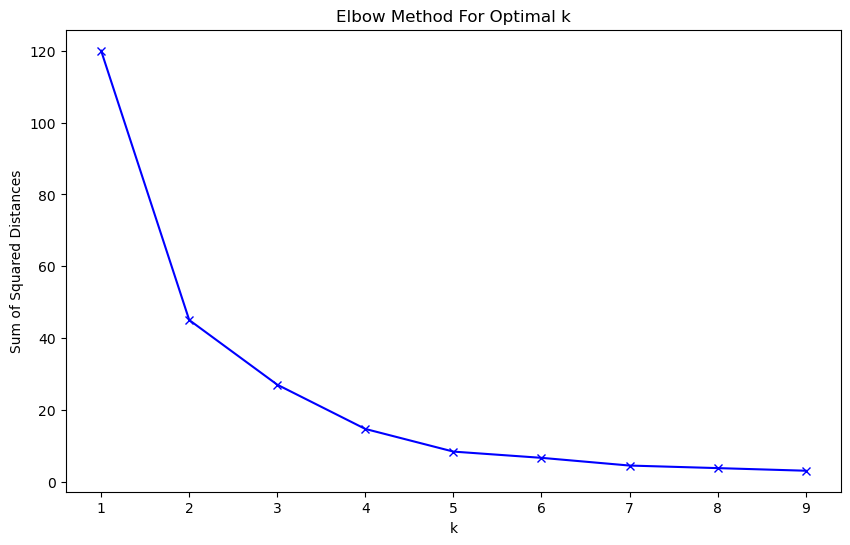

In [69]:
#Range of k values to try
k_values = range(1, 10)

#Calculating the sum of squared distances for each k
sum_of_squared_distances = []
for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans = kmeans.fit(hq_features_scaled)
    sum_of_squared_distances.append(kmeans.inertia_)

#Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [70]:
kmeans = KMeans(n_clusters = 4)
clusters = kmeans.fit_predict(hq_features_scaled)

# Adding the cluster labels to the DataFrame
hq_trail_features['cluster'] = clusters

/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [71]:
hq_trail_features

,total_distance,min_lat,max_lat,min_lon,max_lon,cluster
14542E_2001,6686.617965,33.84300,48.05300,-5.90400,9.22700,2
14551E_1997,19684.465966,-1.64700,54.45300,17.83600,39.97000,0
14551E_1998,15937.566116,2.14000,54.60700,16.67700,37.97500,0
14551E_2000,13866.382648,9.87100,54.30900,20.96100,38.18000,0
14552E_1999,21315.985493,-24.39900,51.76500,16.37400,37.57100,3
14554G_2004,11827.075586,10.47600,33.34000,16.19800,36.18400,1
16896A_2002,16983.359503,11.50100,53.11100,11.87500,39.72600,0
16896A_2003,18326.084385,7.11100,53.38800,11.96600,40.86700,0
16896A_2004,19751.298699,2.63000,52.98700,11.56100,41.93100,0
16896A_2007,15615.294059,9.39000,52.89900,11.89000,35.88400,0


In [72]:
#hq_trail_features.to_csv('data/hq_trail_features.csv')

In [73]:
# Function to create a simple line representing the geotrail
def create_geotrail_line(geoseries, cluster_label):
    #Extract coordinates from the GeoSeries
    line = [(point.y, point.x) for point in geoseries]

    #Assign a color based on the cluster label
    if cluster_label == -1:
        color = 'black'  #color for outliers
    else:
        #Assign a color from a predefined set for clusters
        colors = ['#009E73', '#D55E00', '#0072B2', '#C05DD3']
        color = colors[cluster_label % len(colors)]

    return folium.PolyLine(line, color=color, weight=2.5)

In [76]:
# Create a base map
avg_lat = 25
avg_lon = 10
base_map = folium.Map(location=[avg_lat, avg_lon], zoom_start=2.25)

# Add geotrails to the map
for individual, geoseries in hq_individual_geoseries.items():
    cluster_label = hq_trail_features.loc[individual, 'cluster']
    geotrail_line = create_geotrail_line(geoseries, cluster_label)
    geotrail_line.add_to(base_map)

base_map

### Medium quality individuals

In [31]:
mq_migration_data = pd.read_csv('data/migration_mq.csv')

In [32]:
#Convert the location data to geometry points
mq_migration_data['geometry'] = mq_migration_data.apply(lambda row: Point(row['location-long'], row['location-lat']), axis=1)

In [33]:
#Create a GeoDataFrame
mq_gdf = gpd.GeoDataFrame(mq_migration_data, geometry='geometry')

In [34]:
#Group the data by individual and create a GeoSeries for each one
mq_individuals = mq_gdf.groupby('id_year')
mq_individual_geoseries = {name: gpd.GeoSeries(group['geometry']) for name, group in mq_individuals}

mq_individual_geoseries

{'14542E_2001': 0      POINT (-0.51300 35.12700)
 1      POINT (-0.46900 35.20000)
 2      POINT (-0.55600 35.27000)
 3      POINT (-0.52700 35.27000)
 4      POINT (-0.48800 35.24900)
                  ...            
 130    POINT (-3.36300 34.25300)
 131    POINT (-3.23500 34.25100)
 132    POINT (-3.27200 34.20700)
 133    POINT (-3.40500 34.32200)
 134    POINT (-3.32900 34.22400)
 Name: geometry, Length: 135, dtype: geometry,
 '14542E_2003': 135    POINT (-3.24500 34.19100)
 136    POINT (-3.33400 34.21200)
 137    POINT (-3.32100 34.22200)
 138    POINT (-3.36100 34.18900)
 139    POINT (-3.29100 34.05100)
                  ...            
 222     POINT (9.09700 47.79500)
 223     POINT (9.23400 47.76600)
 224     POINT (9.31600 47.75000)
 225     POINT (9.23100 47.73200)
 226     POINT (9.22600 47.82100)
 Name: geometry, Length: 92, dtype: geometry,
 '14551E_1997': 227    POINT (37.91500 -1.56300)
 228    POINT (37.97500 -1.53100)
 229    POINT (37.89800 -1.59400)
 230    POIN

Extracting features from the geoseries in order to perform the clustering

In [59]:
# Apply the functions to each individual's GeoSeries
mq_individual_distances = {name: calculate_total_distance(geoseries) for name, geoseries in mq_individual_geoseries.items()}
mq_individual_min_max_lat_long = {name: calculate_min_max_lat_long(geoseries) for name, geoseries in mq_individual_geoseries.items()}

# Convert the features to a DataFrame for clustering
mq_individual_distances_df = pd.DataFrame.from_dict(mq_individual_distances, orient='index', columns=['total_distance'])
mq_individual_min_max_lat_long_df = pd.DataFrame.from_dict(mq_individual_min_max_lat_long, orient='index', 
                                                        columns=['min_lat', 'max_lat', 'min_lon', 'max_lon'])

# Merge the two DataFrames on their index
mq_trail_features = pd.merge(mq_individual_distances_df, mq_individual_min_max_lat_long_df, left_index=True, right_index=True)

In [60]:
mq_trail_features

,total_distance,min_lat,max_lat,min_lon,max_lon
14542E_2001,6686.617965,33.84300,48.05300,-5.90400,9.22700
14542E_2003,3267.526596,34.05100,48.07200,-5.83100,9.48400
14551E_1997,19684.465966,-1.64700,54.45300,17.83600,39.97000
14551E_1998,15937.566116,2.14000,54.60700,16.67700,37.97500
14551E_2000,13866.382648,9.87100,54.30900,20.96100,38.18000
14552D_1997,10564.570477,-20.77700,40.42100,22.69600,36.63500
14552E_1999,21315.985493,-24.39900,51.76500,16.37400,37.57100
14554G_2004,11827.075586,10.47600,33.34000,16.19800,36.18400
14555E_1995,4844.246033,11.12200,30.55000,16.41900,33.20500
14555G_1999,14305.036288,-23.38600,38.67700,15.84100,35.78400


Performing a K-means clustering on the data

In [61]:
#Standardizing the features
scaler = StandardScaler()
mq_features_scaled = scaler.fit_transform(mq_trail_features)

/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_

Choosing the optimal K

/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

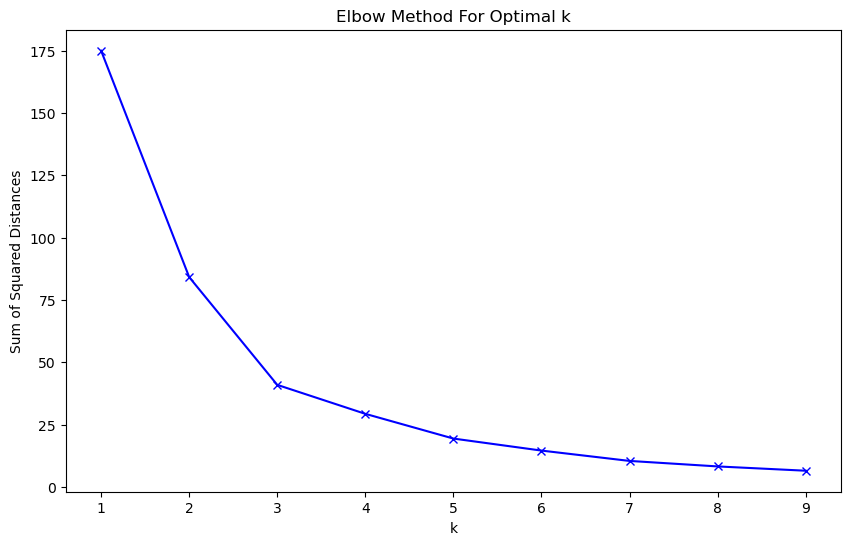

In [62]:
#Range of k values to try
k_values = range(1, 10)

#Calculating the sum of squared distances for each k
sum_of_squared_distances = []
for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans = kmeans.fit(mq_features_scaled)
    sum_of_squared_distances.append(kmeans.inertia_)

#Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [63]:
kmeans = KMeans(n_clusters = 2)
clusters = kmeans.fit_predict(mq_features_scaled)

# Adding the cluster labels to the DataFrame
mq_trail_features['cluster'] = clusters

/Users/khtamkivi/anaconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [64]:
mq_trail_features

,total_distance,min_lat,max_lat,min_lon,max_lon,cluster
14542E_2001,6686.617965,33.84300,48.05300,-5.90400,9.22700,0
14542E_2003,3267.526596,34.05100,48.07200,-5.83100,9.48400,0
14551E_1997,19684.465966,-1.64700,54.45300,17.83600,39.97000,1
14551E_1998,15937.566116,2.14000,54.60700,16.67700,37.97500,1
14551E_2000,13866.382648,9.87100,54.30900,20.96100,38.18000,1
14552D_1997,10564.570477,-20.77700,40.42100,22.69600,36.63500,1
14552E_1999,21315.985493,-24.39900,51.76500,16.37400,37.57100,1
14554G_2004,11827.075586,10.47600,33.34000,16.19800,36.18400,1
14555E_1995,4844.246033,11.12200,30.55000,16.41900,33.20500,1
14555G_1999,14305.036288,-23.38600,38.67700,15.84100,35.78400,1


In [65]:
#mq_trail_features.to_csv('data/mq_trail_features.csv')

In [75]:
# Create a base map
avg_lat = 25
avg_lon = 10
base_map = folium.Map(location=[avg_lat, avg_lon], zoom_start=2.25)

# Add geotrails to the map
for individual, geoseries in mq_individual_geoseries.items():
    cluster_label = mq_trail_features.loc[individual, 'cluster']
    geotrail_line = create_geotrail_line(geoseries, cluster_label)
    geotrail_line.add_to(base_map)

base_map